In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

#from wordcloud import WordCloud
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

# Reset individual options to default
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

# Set desired options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/content/training.csv',header=None)
validation = pd.read_csv('/content/validation.csv',header=None)

train.columns=['Tweet ID','Entity','Sentiment','Tweet Content']
validation.columns=['Tweet ID','Entity','Sentiment','Tweet Content']

print("Training DataSet: \n")
train = train.sample(5000)
display(train.head())

Training DataSet: 



,Tweet ID,Entity,Sentiment,Tweet Content
42867,10153,PlayerUnknownsBattlegrounds(PUBG),Negative,NaN
57343,11436,TomClancysRainbowSix,Positive,@ Rainbow6Game one cool thing you should view is drone fur
18287,9934,PlayStation5(PS5),Neutral,"I said you wouldn’t get a ps5 but fuck hell GT7 seems like its GT4: 2 (which is a good thing, a damn good thing), Although the new Spider-Man talks like it’ll be pretty good, The ratchet & clank’s..."
50785,6317,FIFA,Negative,Playing with Oscar at Fifa gives me grey hair
44874,11706,Verizon,Positive,"Watching @DaveJMatthews perform live on Twitter @verizon . Turns out, this is still ABSOLUTELY my happy place!"


In [3]:
print("Validation DataSet: \n")
display(validation.head())

Validation DataSet: 



,Tweet ID,Entity,Sentiment,Tweet Content
0,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma..."
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Chromebook? 🙄
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking, it's a truly awful game."
4,4433,Google,Neutral,Now the President is slapping Americans in the face that he really did commit an unlawful act after his acquittal! From Discover on Google vanityfair.com/news/2020/02/t…


In [4]:
train = train.dropna(subset=['Tweet Content'])

display(train.isnull().sum())
print("*****"* 5)
display(validation.isnull().sum())

,0
Tweet ID,0
Entity,0
Sentiment,0
Tweet Content,0


*************************


,0
Tweet ID,0
Entity,0
Sentiment,0
Tweet Content,0


In [5]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

In [6]:
import pandas as pd

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts for train and validation data
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Combine counts into a single DataFrame
combined_counts = pd.concat([sentiment_counts_train, sentiment_counts_validation], axis=1)

# Fill missing values (if any) with 0
combined_counts.fillna(0, inplace=True)

# Rename columns
combined_counts.columns = ['Test Data', 'Validation Data']  # Set desired column names

combined_counts

,Test Data,Validation Data
Sentiment,,
Negative,1473,266
Positive,1385,277
Neutral,1246,285
Irrelevant,830,172


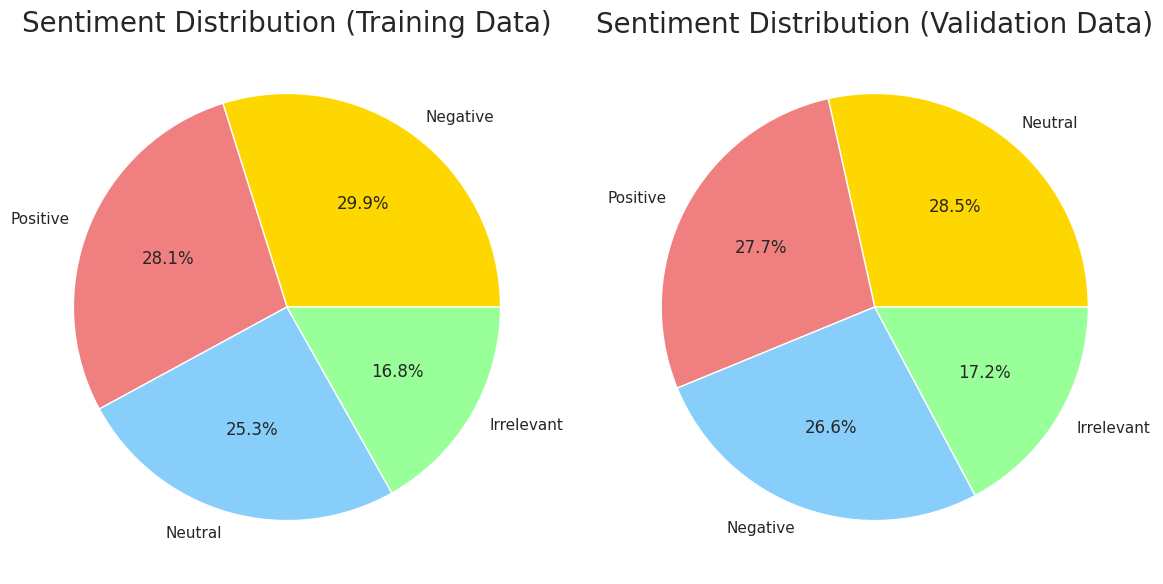

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Create subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for better view

# Create pie chart for training data
ax1.pie(sentiment_counts_train, labels=sentiment_counts_train.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax1.set_title('Sentiment Distribution (Training Data)', fontsize=20)

# Create pie chart for validation data
ax2.pie(sentiment_counts_validation, labels=sentiment_counts_validation.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax2.set_title('Sentiment Distribution (Validation Data)', fontsize=20)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [8]:
# Calculate the value counts of 'Entity'
entity_counts = train['Entity'].value_counts()

# Get the top 9 names
top_names = entity_counts.head(19)

# Aggregate the tenth name as 'Other'
other_count = entity_counts[19:].sum()
top_names['Other'] = other_count

# Display the top 19 names and 'Other'
top_names.to_frame()

,count
Entity,
TomClancysRainbowSix,171
Facebook,170
Hearthstone,169
WorldOfCraft,169
Battlefield,166
Cyberpunk2077,163
Nvidia,163
Xbox(Xseries),162
CallOfDutyBlackopsColdWar,161


In [9]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Calculate the percentages
percentages = (top_names / top_names.sum()) * 100

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=percentages.index,
    values=percentages,
    textinfo='label+percent',
    insidetextorientation='radial'
)])

# Update layout
fig.update_layout(
    title_text='Top Names with Percentages',
    showlegend=False
)

# Show the plot
fig.show()

In [10]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [11]:
import pandas as pd
import plotly.graph_objects as go

# Assuming you've already run the data preprocessing steps
data = train[['Tweet Content', 'Sentiment']]

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

# Use the entire training data as data_train
data_train = data

# Use validation data as data_test
data_test = validation[['Tweet Content', 'Sentiment']]
data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])
data_test['Sentiment'] = data_test['Sentiment_label'].cat.codes

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_train.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_train[k].tolist()[:10] for k in data_train.columns],
        fill_color=[
            'lightcyan',  # Tweet Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 10 Rows of Training Data',
    width=1000,
    height=500,
)

fig.show()


In [12]:
import plotly.graph_objects as go

# Create a colorful table using Plotly for the test data
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_test.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_test[k].tolist()[:5] for k in data_test.columns],  # Show first 5 rows
        fill_color=[
            'lightcyan',  # Tweet Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 5 Rows of Test Data',
    width=1000,
    height=500,
)

# Show the figure
fig.show()

# If you want to save the figure as an HTML file, uncomment the following line:
# fig.write_html("test_data_sample.html")

# BERT (Bidirectional Encoder Representations from Transformers)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #FAFAD2; padding: 1em; margin:3px;font-size:20px;font-family:Comic Sans Ms;color:#660000;letter-spacing:0.7px;text-align: justify;">

**BERT: Bidirectional Encoder Representations from Transformers**

BERT is a groundbreaking language model that has significantly advanced the field of Natural Language Processing (NLP).

It stands for Bidirectional Encoder Representations from Transformers.

**Key Concepts**

- **Bidirectional:** Unlike previous models that processed text sequentially (left to right or right to left), BERT considers the entire context of a word, both preceding and following it. This enables a deeper understanding of language nuances.
- **Encoder:** BERT focuses on understanding the input text rather than generating new text. It extracts meaningful representations from the input sequence.
- **Transformers:** The underlying architecture of BERT is based on the Transformer model, known for its efficiency in handling long sequences and capturing dependencies between words.

**How BERT Works**

- **Pre-training:** BERT is initially trained on a massive amount of text data (like Wikipedia and BooksCorpus) using two unsupervised tasks:
  - **Masked Language Modeling (MLM):** Randomly masks some words in the input and trains the model to predict the masked words based on the context of surrounding words.
  - **Next Sentence Prediction (NSP):** Trains the model to predict whether two given sentences are consecutive in the original document.
- **Fine-tuning:** After pre-training, BERT can be adapted to specific NLP tasks with minimal additional training. This is achieved by adding a task-specific output layer to the pre-trained model.

**Advantages of BERT**

- **Strong performance:** BERT has achieved state-of-the-art results on a wide range of NLP tasks, including question answering, text classification, named entity recognition, and more.
- **Efficiency:** Fine-tuning BERT for new tasks is relatively quick and requires less data compared to training models from scratch.
- **Versatility:** BERT can be applied to various NLP problems with minimal modifications.

**Applications of BERT**

- **Search engines:** Improving search relevance and understanding user queries.
- **Chatbots:** Enhancing natural language understanding and generating more human-like responses.
- **Sentiment analysis:** Accurately determining the sentiment expressed in text.
- **Machine translation:** Improving the quality of translated text.
- **Text summarization:** Generating concise summaries of lengthy documents.

In essence, BERT is a powerful language model that has revolutionized NLP by capturing the bidirectional context of words and enabling efficient transfer learning for various tasks.


<center> <img src="https://lesdieuxducode.com/images/blog/pauldenoyes@expaceocom/BERT-Transformer-Architecture-Globale.png" width="600" height="200"> </center>

In [14]:
%%time

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the dataF
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3})
    return df['Tweet Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and create datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model_BERT
model_BERT = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BERT.to(device)

# Set up optimizer
optimizer = AdamW(model_BERT.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_BERT.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_BERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_BERT.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_BERT(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')


# Save the model_BERT
torch.save(model_BERT.state_dict(), 'sentiment_model_BERT.pth')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.5920
Epoch 2/3, Test Accuracy: 0.6200
Epoch 3/3, Test Accuracy: 0.6490
CPU times: user 5min 45s, sys: 998 ms, total: 5min 46s
Wall time: 5min 56s


In [15]:
# Final evaluation
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

              precision    recall  f1-score   support

    Negative       0.58      0.88      0.70       266
     Neutral       0.65      0.62      0.64       285
    Positive       0.77      0.66      0.71       277
  Irrelevant       0.64      0.31      0.42       172

    accuracy                           0.65      1000
   macro avg       0.66      0.62      0.62      1000
weighted avg       0.66      0.65      0.64      1000



In [16]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2, 3]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix BERT \n")
confusion_matrix_BERT

Confusion matrix BERT 



array([[234,  19,   7,   6],
       [ 78, 178,  18,  11],
       [ 41,  39, 183,  14],
       [ 48,  39,  31,  54]])

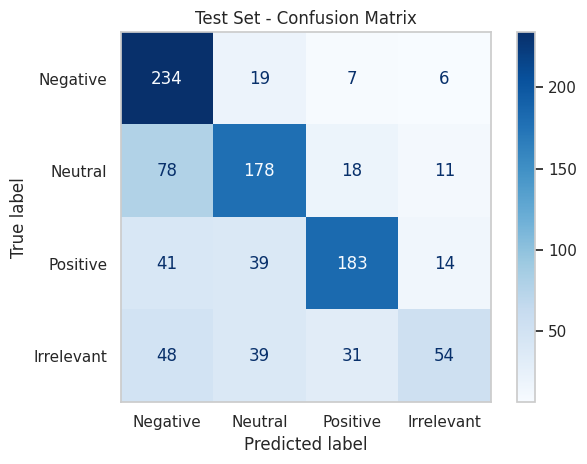

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# RoBERTa (Robustly Optimized BERT Pretraining Approach)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #FAFAD2; padding: 1em; margin:3px;font-size:20px;font-family:Comic Sans Ms;color:#660000;letter-spacing:0.7px;text-align: justify;">

**RoBERTa: A Robustly Optimized BERT Approach**

RoBERTa is an improved version of the BERT (Bidirectional Encoder Representations from Transformers) model. It builds upon BERT's architecture but incorporates several key modifications to enhance its performance.

**Key Differences from BERT**

- **Larger Training Dataset:** RoBERTa was trained on a significantly larger dataset compared to the original BERT, leading to a richer understanding of language.
- **Dynamic Masking:** Unlike BERT's static masking during pre-training, RoBERTa applies dynamic masking, where the masked tokens are changed multiple times for each training instance. This forces the model to learn more robust representations.
- **Longer Training:** RoBERTa undergoes a longer training process with larger batch sizes, allowing it to converge to a better optimum.
- **Removal of Next Sentence Prediction (NSP):** RoBERTa eliminates the NSP objective, focusing solely on Masked Language Modeling (MLM). This change simplifies the training process and improves performance on downstream tasks.
- **Increased Sequence Length:** RoBERTa can handle longer input sequences, enabling it to process more context-rich information.

**Benefits of RoBERTa**

- **Improved Performance:** RoBERTa consistently outperforms BERT on a wide range of NLP tasks, achieving state-of-the-art results.
- **Efficiency:** The modifications in RoBERTa lead to faster training and convergence.
- **Versatility:** Like BERT, RoBERTa can be fine-tuned for various NLP tasks, including text classification, question answering, and more.

**Applications**

- **Search Engines:** Enhancing search relevance and understanding user queries.
- **Chatbots:** Improving natural language understanding and generating more human-like responses.
- **Sentiment Analysis:** Accurately determining the sentiment expressed in text.
- **Machine Translation:** Enhancing the quality of translated text.
- **Text Summarization:** Generating concise summaries of lengthy documents.

In conclusion, RoBERTa is a powerful language model that builds upon the success of BERT by incorporating several refinements. Its improved performance and versatility make it a popular choice for various NLP applications.

In [19]:
%%time

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3})
    return df['Tweet Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and create datasets
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model_RoBERTa = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_RoBERTa.to(device)

# Set up optimizer
optimizer = AdamW(model_RoBERTa.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_RoBERTa.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_RoBERTa(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_RoBERTa.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_RoBERTa(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')


# Save the model
torch.save(model_RoBERTa.state_dict(), 'sentiment_RoBERTa_model.pth')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.5950
Epoch 2/3, Test Accuracy: 0.6570
Epoch 3/3, Test Accuracy: 0.6750
CPU times: user 5min 47s, sys: 1.82 s, total: 5min 49s
Wall time: 6min 6s


In [20]:
# Final evaluation
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

              precision    recall  f1-score   support

    Negative       0.69      0.82      0.75       266
     Neutral       0.75      0.55      0.64       285
    Positive       0.63      0.86      0.72       277
  Irrelevant       0.65      0.37      0.47       172

    accuracy                           0.68      1000
   macro avg       0.68      0.65      0.65      1000
weighted avg       0.68      0.68      0.66      1000



In [21]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2, 3]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_RoBERTa = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix RoBERTa \n")
confusion_matrix_RoBERTa

Confusion matrix RoBERTa 



array([[217,  14,  32,   3],
       [ 49, 157,  54,  25],
       [ 18,  16, 237,   6],
       [ 31,  21,  56,  64]])

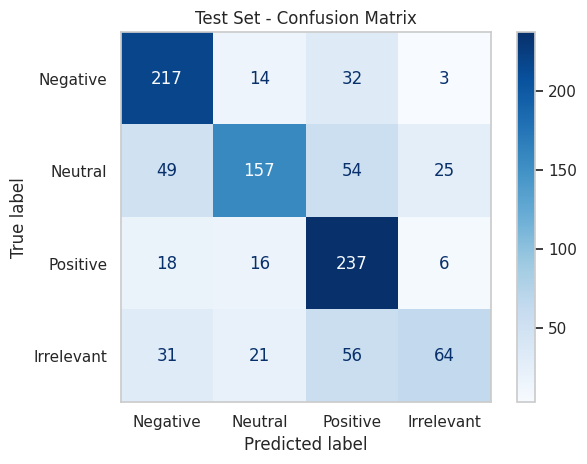

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_RoBERTa, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# DistilBERT (Distilled version of BERT)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #FAFAD2; padding: 1em; margin:3px;font-size:20px;font-family:Comic Sans Ms;color:#660000;letter-spacing:0.7px;text-align: justify;">

**DistilBERT: A Smaller, Faster BERT**

DistilBERT is a smaller and faster version of the BERT model. It's created using a technique called knowledge distillation. This means that a smaller model (the student) learns to mimic the behavior of a larger, more complex model (the teacher). In this case, the teacher is BERT.

**Key Features**

- **Smaller size:** DistilBERT is about 40% smaller than BERT, making it more efficient in terms of memory and computation.
- **Faster:** It's also significantly faster than BERT, making it suitable for real-time applications.
- **Comparable performance:** Despite its smaller size, DistilBERT retains about 95% of BERT's language understanding capabilities.

**How it Works**

- **Knowledge Distillation:** The process involves training DistilBERT to predict the same outputs as BERT for a given input. However, instead of using hard labels (the correct answer), DistilBERT is trained on softened outputs from BERT. This allows the smaller model to learn more generalizable knowledge.
- **Architecture Simplification:** Some architectural elements of BERT, such as the token type embeddings, are removed to reduce complexity.

**Advantages**

- **Efficiency:** Smaller size and faster inference speed make it suitable for resource-constrained environments.
- **Cost-effective:** Lower computational requirements lead to reduced training and inference costs.
- **Good performance:** Despite its smaller size, it maintains a high level of performance on various NLP tasks.

**Applications**

- **Text classification:** Sentiment analysis, topic modeling
- **Named entity recognition:** Identifying entities in text (e.g., persons, organizations, locations)
- **Question answering:** Finding answers to questions based on given text
- **Text generation:** Summarization, translation

In summary, DistilBERT offers a compelling balance between model size, speed, and performance. It's a valuable tool for NLP practitioners looking to deploy models efficiently without sacrificing accuracy.

<center> <img src="https://www.researchgate.net/profile/Alhassan-Mabrouk/publication/358239462/figure/fig2/AS:1120931644747777@1644262338087/The-DistilBERT-model-architecture-and-components.png" width="600" height="200"> </center>

In [23]:
%%time

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3})
    return df['Tweet Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and create datasets
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model DistilBERT
model_DistilBERT = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_DistilBERT.to(device)

# Set up optimizer
optimizer = AdamW(model_DistilBERT.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_DistilBERT.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_DistilBERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_DistilBERT.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_DistilBERT(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')


# Save the model_DistilBERT
torch.save(model_DistilBERT.state_dict(), 'sentiment_model_distilbert.pth')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.5760
Epoch 2/3, Test Accuracy: 0.6440
Epoch 3/3, Test Accuracy: 0.6640
CPU times: user 2min 55s, sys: 1.05 s, total: 2min 56s
Wall time: 3min 8s


In [24]:
# Final evaluation
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

              precision    recall  f1-score   support

    Negative       0.63      0.82      0.71       266
     Neutral       0.63      0.68      0.66       285
    Positive       0.75      0.72      0.74       277
  Irrelevant       0.63      0.31      0.41       172

    accuracy                           0.66      1000
   macro avg       0.66      0.63      0.63      1000
weighted avg       0.67      0.66      0.65      1000



In [25]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2, 3]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_DistilBERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix DistilBERT \n")
confusion_matrix_DistilBERT

Confusion matrix DistilBERT 



array([[217,  35,   8,   6],
       [ 52, 195,  20,  18],
       [ 29,  42, 199,   7],
       [ 45,  37,  37,  53]])

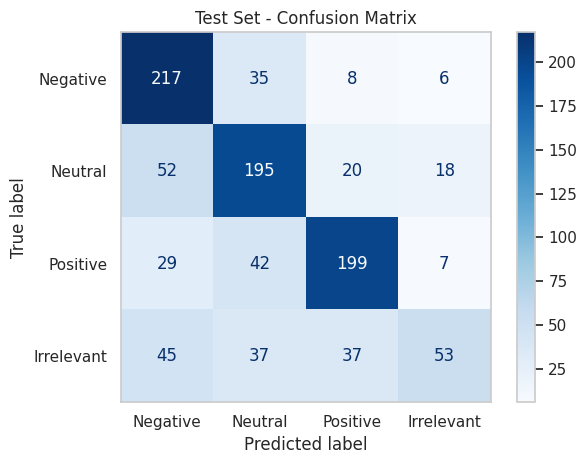

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_DistilBERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ALBERT (A Lite BERT)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #FAFAD2; padding: 1em; margin:3px;font-size:20px;font-family:Comic Sans Ms;color:#660000;letter-spacing:0.7px;text-align: justify;">

**ALBERT: A Lite BERT for Self-Supervised Learning**

ALBERT stands for A Lite BERT for Self-Supervised Learning. It's a language model developed by Google AI, designed to be more efficient and effective than the original BERT model.

**Key Improvements Over BERT**

- **Parameter Reduction:** ALBERT significantly reduces the number of parameters compared to BERT, making it more computationally efficient and faster to train. This is achieved by:
- **Factorized embedding parameterization:** Separating the embedding space into two smaller spaces, reducing the number of parameters.
- **Cross-layer parameter sharing:** Sharing parameters across different layers to reduce redundancy.
- **Sentence-Order Prediction (SOP):** Instead of the Next Sentence Prediction (NSP) task used in BERT, ALBERT employs SOP. This task is more challenging and helps the model better understand sentence relationships.

**Architecture**

*ALBERT maintains the overall transformer architecture of BERT but incorporates the aforementioned improvements. It consists of:*

- **Embedding layer:** Converts input tokens into numerical representations.
- **Transformer encoder:** Processes the input sequence and captures contextual information.
- **Output layer:** Predicts the masked words and sentence order.

**Benefits of ALBERT**

- **Efficiency:** ALBERT is significantly smaller and faster to train than BERT.
- **Improved Performance:** Despite its smaller size, ALBERT often achieves better or comparable performance to BERT on various NLP tasks.
- **Versatility:** Like BERT, ALBERT can be fine-tuned for various NLP tasks.

**Applications**

- **Text classification:** Sentiment analysis, topic modeling
- **Question answering:** Answering questions based on given text
- **Named entity recognition:** Identifying entities in text (e.g., persons, organizations, locations)
- **Text summarization:** Generating concise summaries of lengthy documents

In summary, ALBERT is a powerful language model that addresses some of the limitations of BERT while maintaining its strengths. It offers a good balance between model size, speed, and performance, making it a popular choice for various NLP applications.

<center> <img src="https://congchan.github.io/images/transformer_encoder.png" width="600" height="200"> </center>

In [27]:
%%time

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3})
    return df['Tweet Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and create datasets
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
model_ALBERT = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ALBERT.to(device)

# Set up optimizer
optimizer = AdamW(model_ALBERT.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_ALBERT.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_ALBERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_ALBERT.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_ALBERT(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')

# Final evaluation
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

# Save the model
torch.save(model_ALBERT.state_dict(), 'sentiment_model_albert.pth')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.4730
Epoch 2/3, Test Accuracy: 0.4870
Epoch 3/3, Test Accuracy: 0.5280
              precision    recall  f1-score   support

    Negative       0.49      0.82      0.61       266
     Neutral       0.64      0.35      0.46       285
    Positive       0.53      0.76      0.62       277
  Irrelevant       0.00      0.00      0.00       172

    accuracy                           0.53      1000
   macro avg       0.41      0.48      0.42      1000
weighted avg       0.46      0.53      0.46      1000

CPU times: user 5min 45s, sys: 11.5 s, total: 5min 56s
Wall time: 6min 4s


In [28]:
# Final evaluation
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

              precision    recall  f1-score   support

    Negative       0.49      0.82      0.61       266
     Neutral       0.64      0.35      0.46       285
    Positive       0.53      0.76      0.62       277
  Irrelevant       0.00      0.00      0.00       172

    accuracy                           0.53      1000
   macro avg       0.41      0.48      0.42      1000
weighted avg       0.46      0.53      0.46      1000



In [29]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2, 3]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_ALBERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix ALBERT \n")
confusion_matrix_ALBERT

Confusion matrix ALBERT 



array([[217,  16,  33,   0],
       [106, 101,  78,   0],
       [ 49,  18, 210,   0],
       [ 72,  22,  78,   0]])

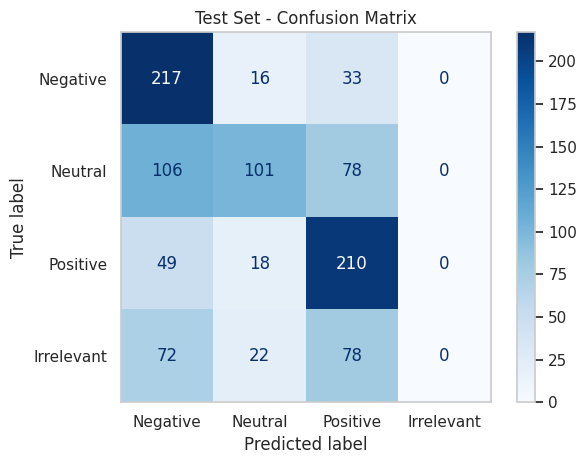

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_ALBERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# XLNet

<blockquote style="margin-right:auto; margin-left:auto; background-color: #FAFAD2; padding: 1em; margin:3px;font-size:20px;font-family:Comic Sans Ms;color:#660000;letter-spacing:0.7px;text-align: justify;">

**XLNet: Going Beyond BERT**

XLNet is a powerful language model that builds upon the successes of its predecessor, BERT, while addressing some of its limitations.

**It stands for "Extreme Language Model".**

**Key Differences from BERT**

- **Autoregressive vs. Autoencoding:** While BERT is an autoencoding model, XLNet is an autoregressive model. This means that XLNet predicts the next token in a sequence given the previous ones, similar to how we humans generate text. This approach allows XLNet to capture bidirectional context without the limitations of BERT's masked language modeling.
- **Permutation Language Model:** XLNet introduces the concept of a permutation language model. Instead of training on a fixed order of tokens, it considers all possible permutations of the input sequence. This enables the model to learn dependencies between any two tokens in the sequence, regardless of their position.

**How XLNet Works**

- **Permutation Language Modeling:** XLNet randomly permutes the input sequence and trains the model to predict the masked tokens in any position based on the context of the remaining tokens.
- **Attention Mechanism:** Similar to BERT, XLNet uses a self-attention mechanism to capture dependencies between different parts of the input sequence.
- **Two-Stream Self-Attention:** XLNet employs two streams of self-attention:
- **Content stream:** Focuses on the content of the tokens.
- **Query stream:** Focuses on the position of the tokens in the permutation.

**Advantages of XLNet**

- **Bidirectional Context:** XLNet can capture bidirectional context more effectively than BERT, leading to improved performance on various NLP tasks.
- **Flexibility:** The permutation language modeling approach allows for more flexible modeling of language.
- **Strong Performance:** XLNet has achieved state-of-the-art results on many NLP benchmarks.

**Applications of XLNet**

- *Text classification*
- *Question answering*
- *Natural language inference*
- *Machine translation*
- *Text summarization*

In summary, XLNet is a significant advancement in the field of natural language processing, offering improved performance and flexibility compared to previous models. Its ability to capture bidirectional context effectively makes it a powerful tool for various NLP applications.

In [37]:
%%time
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3})
    return df['Tweet Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and create datasets
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model XLNet
model_XLNet = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_XLNet.to(device)

# Set up optimizer
optimizer = AdamW(model_XLNet.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_XLNet.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_XLNet(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_XLNet.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels']
            outputs = model_XLNet(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')

# Save the model_XLNet
torch.save(model_XLNet.state_dict(), 'sentiment_model_xlnet.pth')

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Epoch 1/3, Test Accuracy: 0.5640
Epoch 2/3, Test Accuracy: 0.6320
Epoch 3/3, Test Accuracy: 0.6520
CPU times: user 6min 52s, sys: 51.3 s, total: 7min 44s
Wall time: 7min 50s


In [38]:
# Final evaluation
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

              precision    recall  f1-score   support

    Negative       0.68      0.79      0.73       266
     Neutral       0.66      0.63      0.64       285
    Positive       0.61      0.85      0.71       277
  Irrelevant       0.81      0.15      0.25       172

    accuracy                           0.65      1000
   macro avg       0.69      0.61      0.59      1000
weighted avg       0.68      0.65      0.62      1000



In [39]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2, 3]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_XLNet = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix XLNet \n")
confusion_matrix_XLNet

Confusion matrix XLNet 



array([[211,  23,  30,   2],
       [ 47, 179,  56,   3],
       [ 16,  24, 236,   1],
       [ 38,  46,  62,  26]])

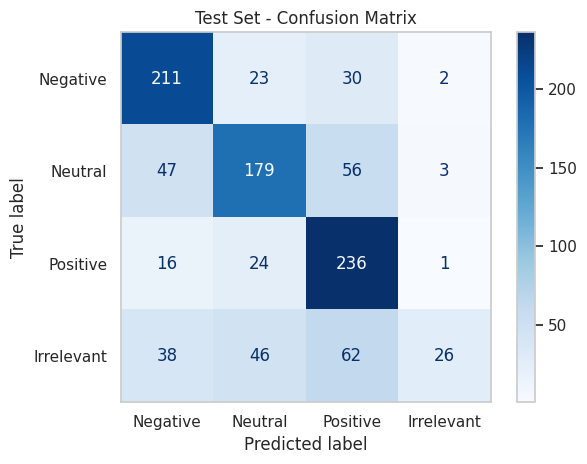

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_XLNet, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

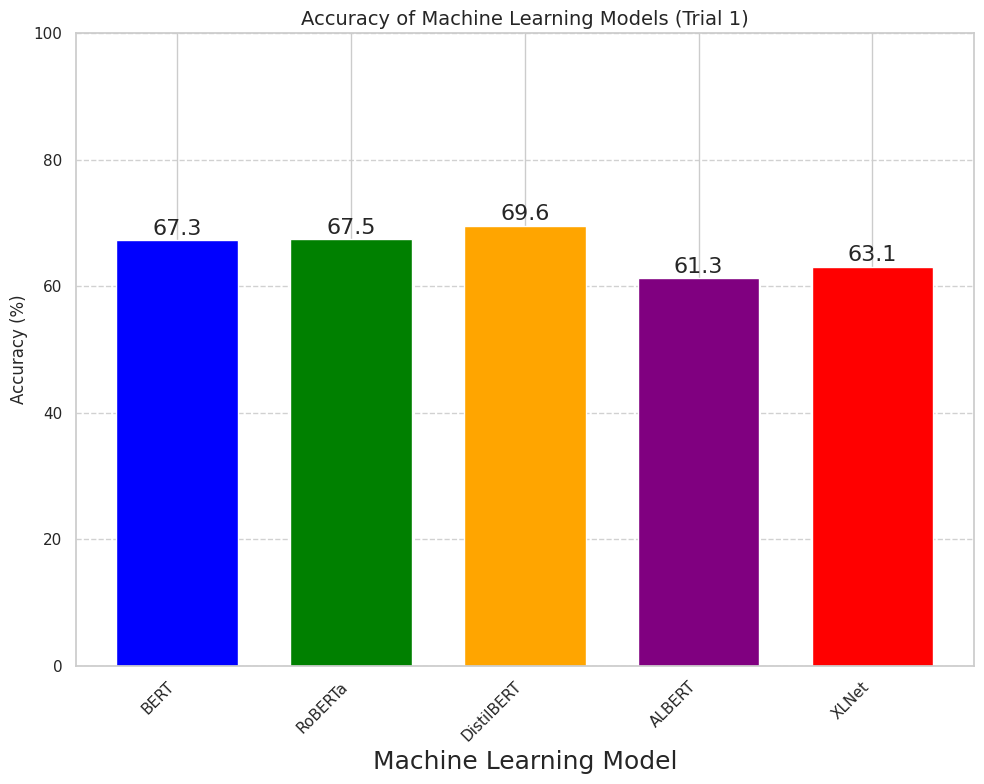

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bar graph (only Trial 1)
models = ["BERT", "RoBERTa", "DistilBERT", "ALBERT", "XLNet"]

accuracy_trial_1 = [67.3, 67.50, 69.60, 61.3, 63.1]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Set the width of each bar and the positions of the bars
width = 0.7

# Create bars with different colors
colors = ['blue', 'green', 'orange', 'purple', 'red', 'magenta']
ax.bar(models, accuracy_trial_1, width, color=colors)

# Customize the plot
ax.set_ylabel('Accuracy (%)', fontsize=12)  # Increase font size for y-axis label
ax.set_xlabel('Machine Learning Model', fontsize=18)  # Increase font size for x-axis label
ax.set_title('Accuracy of Machine Learning Models (Trial 1)', fontsize=14)  # Increase font size for title

# Setxticks and rotate x-axis labels for better readability
ax.set_xticks(models)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=11)  # Increase font size for x-axis tick labels

# Add value labels on top of each bar with increased font size
for i, v in enumerate(accuracy_trial_1):
    ax.text(i, v + 0.2, f'{v:.1f}', ha='center', va='bottom', fontsize=16)  # Adjust vertical offset and format to one decimal place

# Set y-axis to start at 0
ax.set_ylim(0, 100)

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.9)

plt.tight_layout()
plt.show()

# T5 (Text-to-Text Transfer Transformer)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #FAFAD2; padding: 1em; margin:3px;font-size:20px;font-family:Comic Sans Ms;color:#660000;letter-spacing:0.7px;text-align: justify;">

**T5: Text-to-Text Transfer Transformer**

*T5 is a powerful language model developed by Google AI that stands for Text-to-Text Transfer Transformer. It's a revolutionary approach to natural language processing (NLP) that treats all tasks as text-to-text problems.*

**Key Features**

- **Unified Text-to-Text Framework:** T5 converts all NLP tasks (translation, summarization, question answering, etc.) into a text-to-text format. This allows for a single model to be trained on a variety of tasks.
- **Encoder-Decoder Architecture:** T5 employs an encoder-decoder architecture, similar to many other sequence-to-sequence models. The encoder processes the input text, while the decoder generates the output text.
- **Massive Pre-training:** T5 is pre-trained on a massive dataset called C4, which consists of 750 GB of clean text data. This extensive pre-training enables the model to learn general language understanding and generation capabilities.

**How it Works**

- **Task Formulation:** Every NLP task is converted into a text-to-text format. For example, for translation, the input would be "translate English to German: [English sentence]" and the output would be the German translation.
- **Pre-training:** T5 is trained on a massive dataset using a combination of supervised and unsupervised learning.
- **Fine-tuning:** For specific tasks, the pre-trained T5 model can be fine-tuned on task-specific data to improve performance.

**Advantages**

- **Versatility:** T5 can handle a wide range of NLP tasks with a single model.
- **Strong Performance:** T5 has achieved state-of-the-art results on many NLP benchmarks.
- **Efficiency:** The unified framework allows for efficient training and inference.

**Applications**

*Machine translation*
*Text summarization*
*Question answering*
*Text generation*
*Text classification*

In summary, T5 is a powerful and versatile language model that has significantly advanced the field of NLP. Its ability to handle various tasks with a single model makes it a valuable tool for many applications.

In [42]:
%%time
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 'positive', 'Negative': 'negative', 'Neutral': 'neutral', 'Irrelevant': 'irrelevant'})
    return df['Tweet Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Prepare input
        input_text = f"sentiment classification: {text}"
        input_encoding = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Prepare target
        target_encoding = self.tokenizer.encode_plus(
            label,
            add_special_tokens=True,
            max_length=10,  # Assuming labels are short
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': input_encoding['input_ids'].flatten(),
            'attention_mask': input_encoding['attention_mask'].flatten(),
            'labels': target_encoding['input_ids'].flatten()
        }

# Initialize tokenizer and create datasets
tokenizer = T5Tokenizer.from_pretrained('t5-small')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model T5
model_T5 = T5ForConditionalGeneration.from_pretrained('t5-small')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_T5.to(device)

# Set up optimizer
optimizer = AdamW(model_T5.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_T5.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_T5(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_T5.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_T5.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=10)
            preds = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            test_preds.extend(preds)
            test_true.extend([tokenizer.decode(label, skip_special_tokens=True) for label in labels])

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')


# Save the model_T5
torch.save(model_T5.state_dict(), 'sentiment_model_t5.pth')

Epoch 1/3, Test Accuracy: 0.2650
Epoch 2/3, Test Accuracy: 0.3220
Epoch 3/3, Test Accuracy: 0.4270
CPU times: user 2min 19s, sys: 651 ms, total: 2min 20s
Wall time: 2min 21s
